### Data analysis with Scikit-learn and astroML (cont.)

scikit-learn is a set of general machine learning libraries written in Python

`pip install -U scikit-learn`

`conda install scikit-learn`

astroML is a set of machine Learning libraries written in Python aimed at astronomical problems

`pip install --pre --upgrade astroML`

They provide opensource, simple and efficient tools to use (they dont always scale to very large data sets). They are built on Numpy, Astropy, SciPy, and matplotlib and have similar interfaces so you can learn one routine and understand how to call many of the other packages

### Density Estimation

One of the first things we want to do is estimate the probability that an object could have a set of properties given an example data set (e.g. given a set of stars what is the probablity that a star choosen at random will have a color $g-r=1.2$ and $r-i=0.5$). To do this we need to know what is the density of stars as a function of color. Or, given a set of points how do we find clusters or estimate the density efficiently?

<u> The _K-means_ algorithm </u>

The first approach for finding clusters that is always taught is $K$-means (simple and works well)

$K$-means partitions points into $K$ disjoint subsets ($C_k$) with each subset containing $N_k$
points 


It minimizes the objective function,
$\sum_{k=1}^K \sum_{i \in C_k} || x_i - \mu_k ||^2$

$\mu_k = \frac{1}{N_k} \sum_{i \in C_k} x_i$ is the mean of the
points in set $C_k$


_Procedure:_

1. define the number of clusters $K$
2. choose the centroid, $\mu_k$, of each of the $K$ clusters
3. assign each point to the cluster that it is closest to
4. update the centroid of each cluster by recomputing $\mu_k$ according to the new assignments.
5. goto (3) until there are no new assignments.

Global optima are not guaranteed but the process never increases the sum-of-squares error.

Typically run multiple times with different starting values for the
centroids of $C_k$.

We will use the data from the SDSS stars where we have measured the metalicity $[Fe/H]$ and $[\alpha/H]$ and we will plot the density of points and look for clusters within these points

scikit-learn uses the same API as before. Define the number of clusters

`clf = KMeans(n_clusters)`

Fit the data to these clusters (i.e. find the centroid of the clusters)

`clf.fit(scaler.fit_transform(X))`


We can remove the mean and scale the data to have unit variance using the preprocessing.StandardScaler functions in scikit-learn. This is a very common operation when analyzing data

`scaler = preprocessing.StandardScaler()`



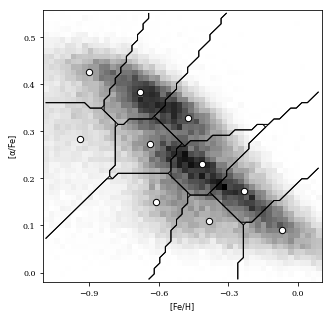

In [1]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import norm

from sklearn.cluster import KMeans
from sklearn import preprocessing

from astroML.datasets import fetch_sdss_sspp

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Get data
data = fetch_sdss_sspp(cleaned=True)
X = np.vstack([data['FeH'], data['alphFe']]).T

# truncate dataset for speed
X = X[::5]

#------------------------------------------------------------
# Compute a 2D histogram  of the input
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'], 50)

#------------------------------------------------------------
# Compute the KMeans clustering
n_clusters = 10

scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
clf.fit(scaler.fit_transform(X))

#------------------------------------------------------------
# Visualize the results
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# plot density
ax = plt.axes()
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

# plot cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
FeH_centers = 0.5 * (FeH_bins[1:] + FeH_bins[:-1])
alphFe_centers = 0.5 * (alphFe_bins[1:] + alphFe_bins[:-1])

Xgrid = np.meshgrid(FeH_centers, alphFe_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(FeH_centers, alphFe_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])

ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

plt.show()

### Exercise 

Increase K (the number of components) to determine how many components are present within the data. How would you determine what the right number might be?

### How to estimate a density _nonparametrically_

This is essentially histograming the data (piecewise constant or top-hat kernel) in multidimensional space

**Kernel Density Estimation**

$N(x) = \frac{1}{Nh^D} \sum_{i=1}^N  K\left( \frac{d(x,x_i)}{h} \right),$

K: kernel (defined by the bandwidth h) is any smooth function which is positive at all values


When we choose the width of the kernel (the bandwidth) we have to decide whether we want to trade off smoothness or accuracy. This is called the bias-variance tradeoff

- Too narrow a kernel, too spiky the results (high variance)

- Too broad a kernel, too smooth or washed out the results (high bias)


Perhaps surprisingly the primary feature is the bandwidth of these distributions not the exact shape.

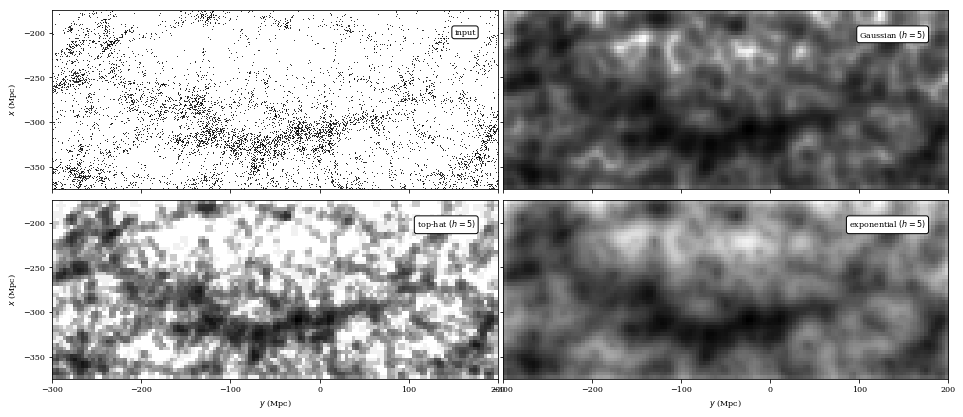

In [2]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.neighbors import KernelDensity

from astroML.datasets import fetch_great_wall

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Fetch the great wall data
X = fetch_great_wall()

#------------------------------------------------------------
# Create  the grid on which to evaluate the results
Nx = 50
Ny = 125
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

#------------------------------------------------------------
# Evaluate for several models
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

kernels = ['gaussian', 'tophat', 'exponential']
dens = []

kde1 = KernelDensity(bandwidth=5, kernel='gaussian')
log_dens1 = kde1.fit(X).score_samples(Xgrid)
dens1 = X.shape[0] * np.exp(log_dens1).reshape((Ny, Nx))

kde2 = KernelDensity(bandwidth=5, kernel='tophat')
log_dens2 = kde2.fit(X).score_samples(Xgrid)
dens2 = X.shape[0] * np.exp(log_dens2).reshape((Ny, Nx))

kde3 = KernelDensity(bandwidth=5, kernel='exponential')
log_dens3 = kde3.fit(X).score_samples(Xgrid)
dens3 = X.shape[0] * np.exp(log_dens3).reshape((Ny, Nx))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(15, 7.5))
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                    hspace=0.01, wspace=0.01)

# First plot: scatter the points
ax1 = plt.subplot(221, aspect='equal')
ax1.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax1.text(0.95, 0.9, "input", ha='right', va='top',
         transform=ax1.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Second plot: gaussian kernel
ax2 = plt.subplot(222, aspect='equal')
ax2.imshow(dens1.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax2.text(0.95, 0.9, "Gaussian $(h=5)$", ha='right', va='top',
         transform=ax2.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Third plot: top-hat kernel
ax3 = plt.subplot(223, aspect='equal')
ax3.imshow(dens2.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax3.text(0.95, 0.9, "top-hat $(h=5)$", ha='right', va='top',
         transform=ax3.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))
ax3.images[0].set_clim(0.01, 0.8)

# Fourth plot: exponential kernel
ax4 = plt.subplot(224, aspect='equal')
ax4.imshow(dens3.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax4.text(0.95, 0.9, "exponential $(h=5)$", ha='right', va='top',
         transform=ax4.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(ymin, ymax - 0.01)
    ax.set_ylim(xmin, xmax)

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax3, ax4]:
    ax.set_xlabel('$y$ (Mpc)')

for ax in [ax2, ax4]:
    ax.yaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax1, ax3]:
    ax.set_ylabel('$x$ (Mpc)')

plt.show()

**Nearest neighbor estimation**

Simple (simplest?) density estimator heavily used in astrophysics (cluster detection, large scale structure measures) 

For each point we find the distance to the $K$th-nearest neighbor, $d_K$.

Implied point density at an arbitrary position $x$ is

$\hat{f}_K(x)  = {K \over V_D(d_K)}$

with $V_D$ the volume. The assumption is that the density is locally constant. Can write it as

$\hat{f}_K(x)  = {C \over d_K^D}$

and calculate $C$ by setting the sum of the product of $\hat{f}_K(x)$ and pixel volume equal to the total number of data points. 

Error on $\hat{f}_K(x)$ is $\sigma_f = K^{1/2}/V_D (d_K)$

Fractional (relative) error is $\sigma_f/\hat{f} = 1/K^{1/2}$.

*   fractional accuracy increases with $K$ at  expense of the spatial resolution 
*   effective resolution scales with $K^{1/D}$

Method can be improved by considering distances to _all_ $K$ nearest neighbors 

$\hat{f}_K(x) = {C \over \sum_{i=1}^K d_i^D}$

Normalization when  computing local density without regard to overall mean density
is

$C  =  \frac{K\, (K + 1)}{2 V_D(r)}$

_Which version is better_? 

*   why not use it all the time?



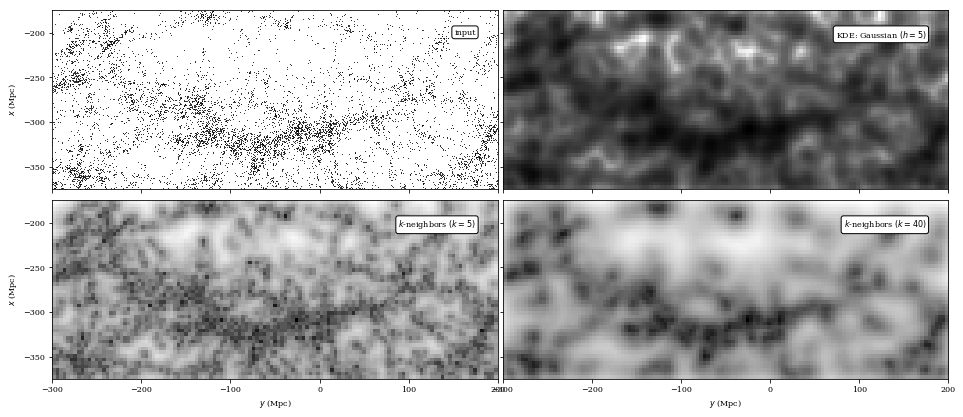

In [4]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.neighbors import KernelDensity
from astroML.datasets import fetch_great_wall
from astroML.density_estimation import KNeighborsDensity

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Fetch the great wall data
X = fetch_great_wall()

#------------------------------------------------------------
# Create  the grid on which to evaluate the results
Nx = 50
Ny = 125
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

#------------------------------------------------------------
# Evaluate for several models
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

kde = KernelDensity(kernel='gaussian', bandwidth=5)
log_pdf_kde = kde.fit(X).score_samples(Xgrid).reshape((Ny, Nx))
dens_KDE = np.exp(log_pdf_kde)

knn5 = KNeighborsDensity('bayesian', 5)
dens_k5 = knn5.fit(X).eval(Xgrid).reshape((Ny, Nx))

knn40 = KNeighborsDensity('bayesian', 40)
dens_k40 = knn40.fit(X).eval(Xgrid).reshape((Ny, Nx))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(15, 7.5))
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                    hspace=0.01, wspace=0.01)

# First plot: scatter the points
ax1 = plt.subplot(221, aspect='equal')
ax1.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax1.text(0.95, 0.9, "input", ha='right', va='top',
         transform=ax1.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Second plot: KDE
ax2 = plt.subplot(222, aspect='equal')
ax2.imshow(dens_KDE.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax2.text(0.95, 0.9, "KDE: Gaussian $(h=5)$", ha='right', va='top',
         transform=ax2.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Third plot: KNN, k=5
ax3 = plt.subplot(223, aspect='equal')
ax3.imshow(dens_k5.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax3.text(0.95, 0.9, "$k$-neighbors $(k=5)$", ha='right', va='top',
         transform=ax3.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Fourth plot: KNN, k=40
ax4 = plt.subplot(224, aspect='equal')
ax4.imshow(dens_k40.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax4.text(0.95, 0.9, "$k$-neighbors $(k=40)$", ha='right', va='top',
         transform=ax4.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(ymin, ymax - 0.01)
    ax.set_ylim(xmin, xmax)

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax3, ax4]:
    ax.set_xlabel('$y$ (Mpc)')

for ax in [ax2, ax4]:
    ax.yaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax1, ax3]:
    ax.set_ylabel('$x$ (Mpc)')

plt.show()

### Mixture Models: Gaussian

Mixture models estimate the density using the sum of functions to represent the density distributions - they are often used in defining the density, classifications, or cloning of a data set....

Gaussian mixture models (GMMs) are the most common implementation of mixture models

$\rho(\mathbf{x}) = N\, p(\mathbf{x})
  = N\, \sum_{j=1}^M \alpha_j \mathcal{N}(\mu_j, \Sigma_j)$
  
with  $p(\mathbf{x}) = \sum_j \alpha_j \mathcal{N}(\mathbf{x}|\mathbf{\mu}_{j},\mathbf{\Sigma}_{j})$

and

$\mathcal{N}(\mathbf{x}|\mathbf{\mu}_j,\mathbf{\Sigma}_j) =
  \frac{1}{\sqrt{(2\pi)^D\mbox{det}(\mathbf{\Sigma}_j)}}
      \exp\Big(-\frac{1}{2}(\mathbf{x}-\mathbf{\mu})^T\mathbf{\Sigma}_j^{-1}(\mathbf{x}-\mathbf{\mu})\Big)\, $



where the model consists of $M$ Gaussians with locations $\mu_j$
and covariances $\Sigma_j$. The log-likelihood is straightforward to define by this model.

<u> _Expectation maximization_ </u> is typically employed to solve for the mixture of Gaussians


- _Expectation_

       Given a set of Gaussians compute the “expected” classes of all points

- _Maximization_

       Estimate the MLE of $\mu$, amplitude, and $\Sigma$ given the data’s class membership 

Iterative proceedure until variance does not change. Guaranteed to converge - **but not to the correct answer**

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from astroML.utils import convert_2D_cov
from astroML.plotting.tools import draw_ellipse

#------------------------------------------------------------
# Set up the dataset
#  We'll use scikit-learn's Gaussian Mixture Model to sample
#  data from a mixture of Gaussians.  The usual way of using
#  this involves fitting the mixture to data: we'll see that
#  below.  Here we'll set the internal means, covariances,
#  and weights by-hand.

# we'll define clusters as (mu, sigma1, sigma2, alpha, frac)
clusters = [((60, 60), 2, 2, np.pi / 2, 0.6),
            ((65, 65), 5, 3, 0., 0.4),]

gmm_input = GaussianMixture(len(clusters), covariance_type='full')
gmm_input.means_ = np.array([c[0] for c in clusters])
gmm_input.covariances_ = np.array([convert_2D_cov(*c[1:4]) for c in clusters])
gmm_input.weights_ = np.array([c[4] for c in clusters])
gmm_input.weights_ /= gmm_input.weights_.sum()
gmm_input.precisions_cholesky_ = 1 / np.sqrt(gmm_input.covariances_)
gmm_input.fit = None

#------------------------------------------------------------
# Compute and plot the results
Nclusters = len(clusters)
Npts = 1000

X = gmm_input.sample(Npts)[0]


def fitAndPlot(X, n_components=2, n_iter=0):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)

    ax.plot(X[:, 0], X[:, 1], '.', c='red', ms=1, zorder=1)

    ax.set_xlim(X[:,0].min(), X[:,0].max())
    ax.set_ylim(X[:,1].min(), X[:,1].max())
    ax.set_ylabel('$y$')
    ax.set_xlabel('$x$')
    
    clf = GaussianMixture(n_components, max_iter=n_iter, 
                          init_params='random', random_state=10)
    clf.fit(X)

    # plot the components
    for i in range(clf.n_components):
        mean = clf.means_[i]
        cov = clf.covariances_[i]
        if cov.ndim == 1:
            cov = np.diag(cov)
        draw_ellipse(mean, cov, ax=ax, fc='none', ec='k', zorder=2, scales=[2])

/Users/ridder/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide


In [6]:
from ipywidgets import interact, interactive, fixed, interact_manual
interact(fitAndPlot, X=fixed(X), n_components=fixed(2), 
         n_iter=(2,20, 1))

interactive(children=(IntSlider(value=2, description='n_iter', max=20, min=2), Output()), _dom_classes=('widge…

<function __main__.fitAndPlot>

### Interpretation and number of Gaussians

Typically used as a a density estimation and not as a way of determining the number of Gaussians in a distribution (e.g. imagine what would happen with a single cluster and a uniform background)

AIC, BIC, and cross-validation (see last lecture) are often used to define the number of parameters (though this is rarely well defined)

Specifying the number of components (or clusters) is a relatively
poorly posed question. It is rare to find distinct, isolated  Gaussian clusters of data  (almost all distributions are continuous). 


@pickle_results: using precomputed results from 'GMM_metallicity.pkl'
best fit converged: True
BIC: n_components =  1


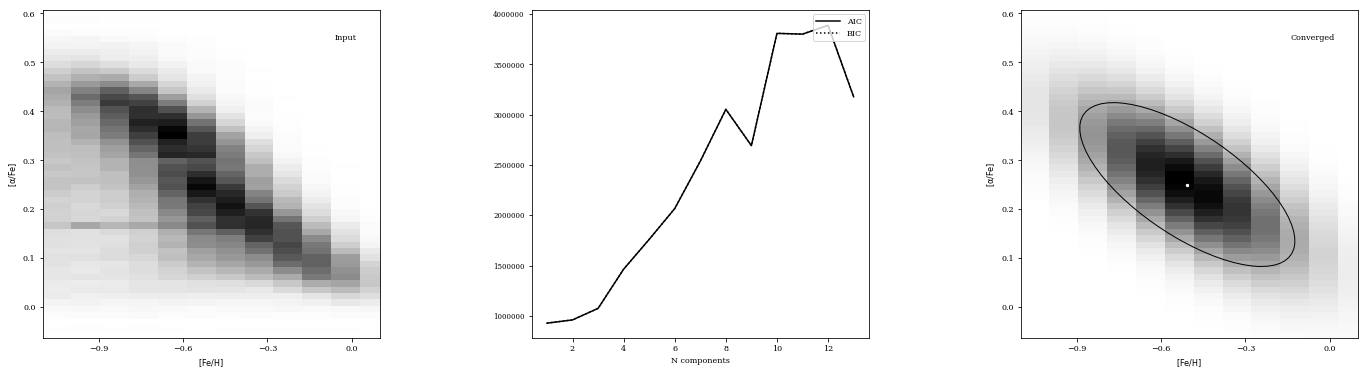

In [9]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.mixture import GaussianMixture

from astroML.datasets import fetch_sdss_sspp
from astroML.utils.decorators import pickle_results
from astroML.plotting.tools import draw_ellipse

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Get the Segue Stellar Parameters Pipeline data
data = fetch_sdss_sspp(cleaned=False)
X = np.vstack([data['FeH'], data['alphFe']]).T

# truncate dataset for speed
X = X[::5]

#------------------------------------------------------------
# Compute GaussianMixture models & AIC/BIC
N = np.arange(1, 14)


@pickle_results("GMM_metallicity.pkl")
def compute_GaussianMixture(N, covariance_type='full', max_iter=1000):
    models = [None for n in N]
    for i in range(len(N)):
        print(N[i])
        models[i] = GaussianMixture(n_components=N[i], max_iter=max_iter,
                                    covariance_type=covariance_type)
        models[i].fit(X)
    return models

models = compute_GaussianMixture(N)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

i_best = np.argmin(BIC)
gmm_best = models[i_best]
print("best fit converged:", gmm_best.converged_)
print("BIC: n_components =  %i" % N[i_best])

#------------------------------------------------------------
# compute 2D density
FeH_bins = 51
alphFe_bins = 51
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'],
                                          (FeH_bins, alphFe_bins))

Xgrid = np.array(list(map(np.ravel,
                          np.meshgrid(0.5 * (FeH_bins[:-1]
                                             + FeH_bins[1:]),
                                      0.5 * (alphFe_bins[:-1]
                                             + alphFe_bins[1:]))))).T
log_dens = gmm_best.score_samples(Xgrid).reshape((51, 51))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(21,7))
fig.subplots_adjust(wspace=0.45,
                    bottom=0.25, top=0.9,
                    left=0.1, right=0.97)

# plot density
ax = fig.add_subplot(131)
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.text(0.93, 0.93, "Input",
        va='top', ha='right', transform=ax.transAxes)

# plot AIC/BIC
ax = fig.add_subplot(132)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, ':k', label='BIC')
ax.legend(loc=1)
ax.set_xlabel('N components')
plt.setp(ax.get_yticklabels(), fontsize=7)

# plot best configurations for AIC and BIC
ax = fig.add_subplot(133)
ax.imshow(np.exp(log_dens),
          origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

ax.scatter(gmm_best.means_[:, 0], gmm_best.means_[:, 1], c='w')
for mu, C, w in zip(gmm_best.means_, gmm_best.covariances_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[1.5], ax=ax, fc='none', ec='k')

ax.text(0.93, 0.93, "Converged",
        va='top', ha='right', transform=ax.transAxes)

ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

plt.show()

Determining the number of Gaussians becomes particularly tricky when you it is not clear what structures you are trying to measure. An example of this is our standard "Great Wall" plot where we want to measure the density of points on the sky

@pickle_results: computing results and saving to 'great_wall_GMM.pkl'
converged: True


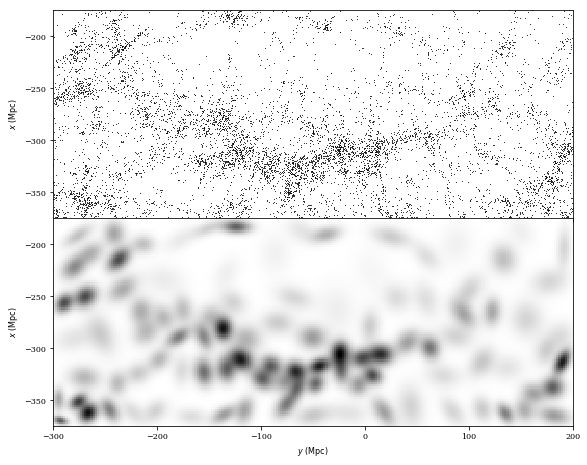

In [10]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.mixture import GaussianMixture
from astroML.datasets import fetch_great_wall
from astroML.utils.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# load great wall data
X = fetch_great_wall()


#------------------------------------------------------------
# Create a function which will save the results to a pickle file
#  for large number of clusters, computation will take a long time!
@pickle_results('great_wall_GMM.pkl')
def compute_GMM(n_clusters, max_iter=1000, tol=3, covariance_type='full'):
    clf = GaussianMixture(n_clusters, covariance_type=covariance_type,
                          max_iter=max_iter, tol=tol, random_state=0)
    clf.fit(X)
    print("converged:", clf.converged_)
    return clf

#------------------------------------------------------------
# Compute a grid on which to evaluate the result
Nx = 100
Ny = 250
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

#------------------------------------------------------------
# Compute the results
#
# we'll use 100 clusters.  In practice, one should cross-validate
# with AIC and BIC to settle on the correct number of clusters.
clf = compute_GMM(n_clusters=100)
log_dens = clf.score_samples(Xgrid).reshape(Ny, Nx)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 7.5))
fig.subplots_adjust(hspace=0, left=0.08, right=0.95, bottom=0.13, top=0.9)

ax = fig.add_subplot(211, aspect='equal')
ax.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)

ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.ylabel(r'$x\ {\rm (Mpc)}$')

ax = fig.add_subplot(212, aspect='equal')
ax.imshow(np.exp(log_dens.T), origin='lower', cmap=plt.cm.binary,
          extent=[ymin, ymax, xmin, xmax])
ax.set_xlabel(r'$y\ {\rm (Mpc)}$')
ax.set_ylabel(r'$x\ {\rm (Mpc)}$')

plt.show()

### Exercise

We can use the density estimation to separate stars from galaxies. The following code will plot the r magnitude against the difference between the r band PSF magnitude (rRawPSF) and the r band model (or aperture) magnitude (rRawPSF) for stars and galaxies in the SDSS.

The stars and galaxies are easily separated in these types of plots - why?

[========================================]  60.58Mb / 60.58Mb   


Text(0, 0.5, '$rPsfMag - rModelMag$')

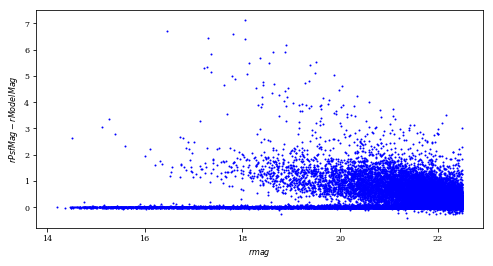

In [11]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors

from astroML.datasets import fetch_imaging_sample

from sklearn.mixture import GaussianMixture
from astroML.plotting.tools import draw_ellipse

#----------------------------------------------------------------------
# get data: returns data and classification (0:star / 1:RR Lyrae)
# data are u-g, g-r, r-i, i-z
#X, y = fetch_rrlyrae_combined()
# get data: returns data and classification (0:star / 1:galaxy)

def get_stars_and_galaxies(Nstars=10000, Ngals=10000):
    """Get the subset of star/galaxy data to plot"""
    data = fetch_imaging_sample()
    objtype = data['type']
    stars = data[objtype == 6][:Nstars]
    galaxies = data[objtype == 3][:Ngals]
    return np.concatenate([stars,galaxies]), np.concatenate([np.zeros(len(stars)),np.ones(len(galaxies))])


data, y = get_stars_and_galaxies(Nstars=10000, Ngals=10000)

# select r model mag and psf - model mag as columns
X = np.column_stack((data['rRaw'], data['rRawPSF'] - data['rRaw']))


#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax.scatter(X[:,[0]], X[:,[1]], s=4, lw=0, cmap=plt.cm.binary)
xlim = (15., 22.5)
ylim = (-0.5, 5.)

ax.set_xlabel('$r mag$')
ax.set_ylabel('$rPsfMag - rModelMag$')



### Exercise 

Use the mixture models to estimate the density of the stars and the density of the galaxies (separately)

Fit a mixture model to the stars and then to the galaxies

Plot the Gaussians for each model on top of the scatter plot


In [ ]:
def fitAndPlot(X, n_components=2, n_iter=0):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)

    ax.plot(X[:, 0], X[:, 1], '.', c='red', ms=1, zorder=1)

    ax.set_xlim(X[:,0].min(), X[:,0].max())
    ax.set_ylim(X[:,1].min(), X[:,1].max())
    ax.set_ylabel('$y$')
    ax.set_xlabel('$x$')
    
    clf = GaussianMixture(n_components, max_iter=n_iter, 
                          init_params='random', random_state=10)
    clf.fit(X)

    # plot the components
    for i in range(clf.n_components):
        mean = clf.means_[i]
        cov = clf.covariances_[i]
        if cov.ndim == 1:
            cov = np.diag(cov)
        draw_ellipse(mean, cov, ax=ax, fc='none', ec='k', zorder=2, scales=[2])